# Portfolio Optimization with Modern Portfolio Theory

**A Professional Investment Analysis Tool**

---

This notebook implements a complete portfolio optimization system based on Harry Markowitz's Modern Portfolio Theory (MPT). We analyze a diversified portfolio of 10 stocks across different sectors and find optimal allocations.

## Key Concepts

**Portfolio Return:** $R_p = \sum_{i=1}^{n} w_i \cdot R_i$

**Portfolio Variance:** $\sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w}$

**Sharpe Ratio:** $S = \frac{R_p - R_f}{\sigma_p}$

Where:
- $w_i$ = weight of asset $i$
- $R_i$ = expected return of asset $i$
- $\Sigma$ = covariance matrix
- $R_f$ = risk-free rate

---


## 1. Setup & Data Loading

First, we import all necessary libraries and configure our analysis parameters.


In [9]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data download
import yfinance as yf

# Portfolio optimization
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting as pfopt_plotting

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#C73E1D',
    'neutral': '#3B3B3B'
}

print("All libraries loaded successfully!")


All libraries loaded successfully!


In [10]:
# Portfolio Configuration
TICKERS = {
    'Tech': ['AAPL', 'MSFT', 'GOOGL'],
    'Finance': ['JPM', 'BAC'],
    'Consumer': ['PG', 'KO'],
    'Healthcare': ['JNJ', 'UNH'],
    'Energy': ['XOM']
}

ALL_TICKERS = [ticker for sector in TICKERS.values() for ticker in sector]
BENCHMARK = 'SPY'  # S&P 500 ETF for comparison

# Analysis parameters
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate
TRADING_DAYS = 252     # Trading days per year

# Date range: 3 years of historical data
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=3*365)

print(f"Portfolio Universe: {len(ALL_TICKERS)} stocks")
print(f"Analysis Period: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"Risk-Free Rate: {RISK_FREE_RATE:.1%}")
print(f"\nSectors and Holdings:")
for sector, tickers in TICKERS.items():
    print(f"  • {sector}: {', '.join(tickers)}")


Portfolio Universe: 10 stocks
Analysis Period: 2022-12-29 to 2025-12-28
Risk-Free Rate: 2.0%

Sectors and Holdings:
  • Tech: AAPL, MSFT, GOOGL
  • Finance: JPM, BAC
  • Consumer: PG, KO
  • Healthcare: JNJ, UNH
  • Energy: XOM


In [11]:
def download_stock_data(tickers: list, start: datetime, end: datetime) -> pd.DataFrame:
    """
    Download historical adjusted close prices for given tickers.
    
    Args:
        tickers: List of stock ticker symbols
        start: Start date for data download
        end: End date for data download
    
    Returns:
        DataFrame with adjusted close prices, indexed by date
    """
    print(f"Downloading data for {len(tickers)} stocks...")
    
    data = yf.download(
        tickers, 
        start=start, 
        end=end, 
        progress=False,
        auto_adjust=True
    )['Close']
    
    # Handle single ticker case
    if isinstance(data, pd.Series):
        data = data.to_frame(name=tickers[0])
    
    # Clean data
    data = data.dropna()
    
    print(f"Downloaded {len(data)} days of data ({data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')})")
    return data

# Download stock data
prices = download_stock_data(ALL_TICKERS, START_DATE, END_DATE)

# Download benchmark data
benchmark_prices = download_stock_data([BENCHMARK], START_DATE, END_DATE)

# Preview data
print(f"\nPrice Data Shape: {prices.shape}")
prices.tail()


Downloaded 751 days of data (2022-12-29 to 2025-12-26)
Downloaded 751 days of data (2022-12-29 to 2025-12-26)

Price Data Shape: (751, 10)


Ticker,AAPL,BAC,GOOGL,JNJ,JPM,KO,MSFT,PG,UNH,XOM
Date,,,,,,,,,,
2025-12-19,273.670013,55.270000,307.160004,206.369995,317.209991,70.059998,485.920013,144.460007,327.420013,116.690002
2025-12-22,270.970001,55.880001,309.779999,207.320007,323.089996,70.209999,484.920013,142.690002,325.160004,118.150002
2025-12-23,272.359985,55.970001,314.350006,205.779999,325.929993,69.870003,486.850006,143.179993,324.799988,119.419998
2025-12-24,273.809998,56.250000,314.089996,207.779999,329.170013,70.110001,488.019989,144.490005,327.579987,119.220001
2025-12-26,273.399994,56.169998,313.510010,207.630005,327.910004,69.870003,487.709991,144.740005,331.829987,119.110001


## 2. Exploratory Data Analysis

Let's visualize our data to understand the characteristics of each stock before optimization.


In [12]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Normalize prices (all start at 100)
normalized_prices = (prices / prices.iloc[0]) * 100

# Interactive normalized price chart
fig = go.Figure()

sector_colors = {
    'Tech': ['#2E86AB', '#1E5F7A', '#0E3849'],
    'Finance': ['#A23B72', '#7A2C56'],
    'Consumer': ['#F18F01', '#C97401'],
    'Healthcare': ['#28A745', '#1E7B34'],
    'Energy': ['#C73E1D']
}

color_idx = 0
for sector, tickers in TICKERS.items():
    colors = sector_colors[sector]
    for i, ticker in enumerate(tickers):
        fig.add_trace(go.Scatter(
            x=normalized_prices.index,
            y=normalized_prices[ticker],
            mode='lines',
            name=f'{ticker} ({sector})',
            line=dict(color=colors[i % len(colors)], width=2),
            hovertemplate=f'{ticker}<br>Date: %{{x}}<br>Value: %{{y:.2f}}<extra></extra>'
        ))

fig.update_layout(
    title='Normalized Stock Prices (Base = 100)',
    xaxis_title='Date',
    yaxis_title='Normalized Price',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)
fig.show()


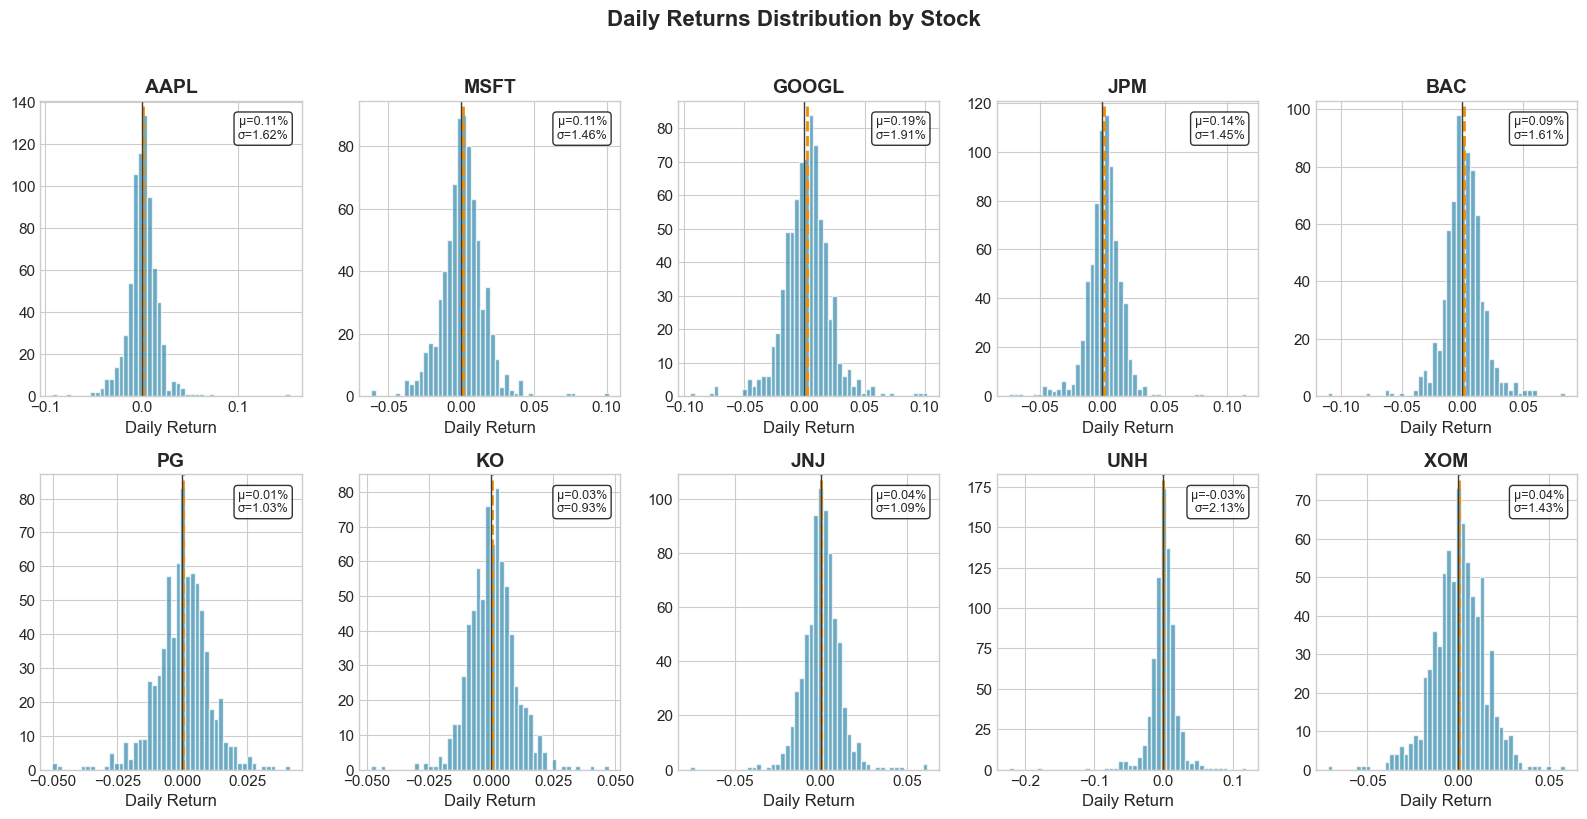

In [13]:
# Daily returns distribution
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for i, ticker in enumerate(ALL_TICKERS):
    ax = axes[i]
    returns[ticker].hist(bins=50, ax=ax, color=COLORS['primary'], alpha=0.7, edgecolor='white')
    ax.axvline(returns[ticker].mean(), color=COLORS['accent'], linestyle='--', linewidth=2, label='Mean')
    ax.axvline(0, color=COLORS['neutral'], linestyle='-', linewidth=1)
    ax.set_title(f'{ticker}', fontweight='bold')
    ax.set_xlabel('Daily Return')
    
    # Add statistics annotation
    mean_ret = returns[ticker].mean() * 100
    std_ret = returns[ticker].std() * 100
    ax.annotate(f'μ={mean_ret:.2f}%\nσ={std_ret:.2f}%', 
                xy=(0.95, 0.95), xycoords='axes fraction',
                ha='right', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Daily Returns Distribution by Stock', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


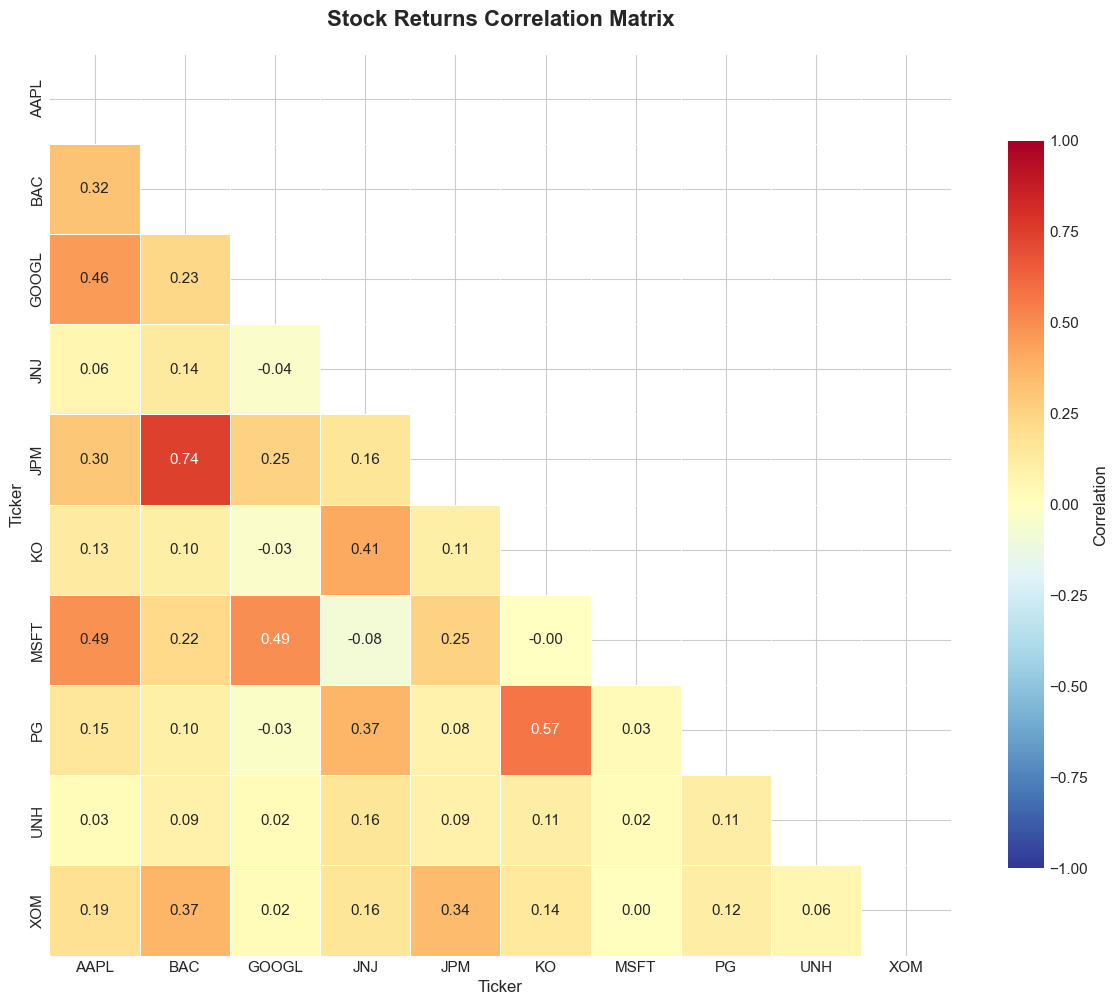


Correlation Insights:
--------------------------------------------------

Highest correlations:
  BAC ↔ JPM: 0.744
  KO ↔ PG: 0.573
  GOOGL ↔ MSFT: 0.494
  AAPL ↔ MSFT: 0.488
  AAPL ↔ GOOGL: 0.457

Lowest correlations (best for diversification):
  GOOGL ↔ UNH: 0.023
  GOOGL ↔ XOM: 0.021
  MSFT ↔ UNH: 0.021
  MSFT ↔ XOM: 0.004
  KO ↔ MSFT: -0.000


In [14]:
# Correlation matrix heatmap
correlation_matrix = returns.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='RdYlBu_r',
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)

plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Key correlation insights
print("\nCorrelation Insights:")
print("-" * 50)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i], 
            correlation_matrix.columns[j], 
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
print("\nHighest correlations:")
for t1, t2, corr in corr_pairs_sorted[:5]:
    print(f"  {t1} ↔ {t2}: {corr:.3f}")

print("\nLowest correlations (best for diversification):")
for t1, t2, corr in corr_pairs_sorted[-5:]:
    print(f"  {t1} ↔ {t2}: {corr:.3f}")


In [15]:
# Annual returns and volatility summary
annual_returns = returns.mean() * TRADING_DAYS
annual_volatility = returns.std() * np.sqrt(TRADING_DAYS)
sharpe_ratios = (annual_returns - RISK_FREE_RATE) / annual_volatility

# Create summary DataFrame
stock_summary = pd.DataFrame({
    'Annual Return': annual_returns,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': sharpe_ratios
}).round(4)

# Assign sectors
stock_summary['Sector'] = stock_summary.index.map(
    lambda x: next((sector for sector, tickers in TICKERS.items() if x in tickers), 'Unknown')
)

# Risk-Return scatter plot with Plotly
stock_summary_plot = stock_summary.reset_index().rename(columns={'index': 'Ticker'})
fig = px.scatter(
    stock_summary_plot,
    x='Annual Volatility',
    y='Annual Return',
    color='Sector',
    size=np.abs(stock_summary_plot['Sharpe Ratio']) + 0.5,
    text='Ticker',
    hover_data=['Sharpe Ratio'],
    color_discrete_map={
        'Tech': '#2E86AB',
        'Finance': '#A23B72',
        'Consumer': '#F18F01',
        'Healthcare': '#28A745',
        'Energy': '#C73E1D'
    }
)

fig.update_traces(textposition='top center', marker=dict(line=dict(width=2, color='white')))

# Add risk-free rate line
fig.add_hline(y=RISK_FREE_RATE, line_dash="dash", line_color="gray", 
              annotation_text="Risk-Free Rate", annotation_position="bottom right")

fig.update_layout(
    title='Risk-Return Profile by Stock',
    xaxis_title='Annual Volatility (Risk)',
    yaxis_title='Annual Return',
    xaxis_tickformat='.1%',
    yaxis_tickformat='.1%',
    template='plotly_white',
    height=500,
    showlegend=True
)
fig.show()

# Display summary table
print("\nIndividual Stock Metrics Summary:")
print("=" * 70)
display_df = stock_summary.copy()
display_df['Annual Return'] = display_df['Annual Return'].apply(lambda x: f"{x:.2%}")
display_df['Annual Volatility'] = display_df['Annual Volatility'].apply(lambda x: f"{x:.2%}")
display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
display(display_df.sort_values(by='Sharpe Ratio', ascending=False))



Individual Stock Metrics Summary:


,Annual Return,Annual Volatility,Sharpe Ratio,Sector
Ticker,,,,
GOOGL,47.38%,30.30%,1.498,Tech
JPM,35.43%,23.08%,1.448,Finance
MSFT,27.17%,23.22%,1.084,Tech
AAPL,28.87%,25.71%,1.045,Tech
BAC,23.64%,25.49%,0.849,Finance
JNJ,9.80%,17.23%,0.453,Healthcare
KO,7.09%,14.74%,0.345,Consumer
XOM,8.97%,22.70%,0.307,Energy
PG,2.12%,16.39%,0.007,Consumer


## 3. Expected Returns & Covariance Matrix

We calculate the inputs needed for portfolio optimization using historical data.


Expected Annual Returns (Historical Mean x 252):
  GOOGL  | Return:  53.37% | Vol:  30.30% | Sharpe:   1.70
  JPM    | Return:  38.75% | Vol:  23.08% | Sharpe:   1.59
  AAPL   | Return:  29.15% | Vol:  25.71% | Sharpe:   1.06
  MSFT   | Return:  27.73% | Vol:  23.22% | Sharpe:   1.11
  BAC    | Return:  22.60% | Vol:  25.49% | Sharpe:   0.81
  JNJ    | Return:   8.68% | Vol:  17.23% | Sharpe:   0.39
  XOM    | Return:   6.59% | Vol:  22.70% | Sharpe:   0.20
  KO     | Return:   6.19% | Vol:  14.74% | Sharpe:   0.28
  PG     | Return:   0.77% | Vol:  16.39% | Sharpe:  -0.07
  UNH    | Return: -12.96% | Vol:  33.88% | Sharpe:  -0.44

Covariance Matrix Visualization:


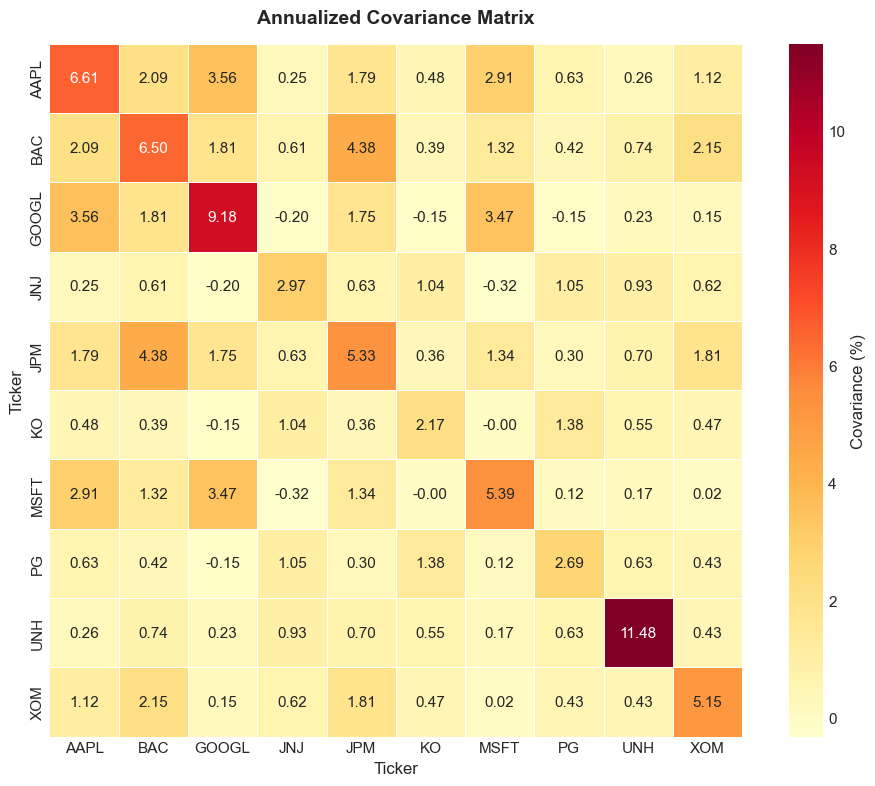

In [16]:
# Calculate expected returns using mean historical returns (annualized)
mu = expected_returns.mean_historical_return(prices)

# Calculate sample covariance matrix (annualized)
S = risk_models.sample_cov(prices)

# Display expected returns summary
print("Expected Annual Returns (Historical Mean x 252):")
print("=" * 50)
expected_returns_df = pd.DataFrame({
    'Expected Return': mu,
    'Volatility': np.sqrt(np.diag(S))
}).sort_values(by='Expected Return', ascending=False)

expected_returns_df['Sharpe'] = (expected_returns_df['Expected Return'] - RISK_FREE_RATE) / expected_returns_df['Volatility']

for ticker in expected_returns_df.index:
    ret = expected_returns_df.loc[ticker, 'Expected Return']
    vol = expected_returns_df.loc[ticker, 'Volatility']
    sharpe = expected_returns_df.loc[ticker, 'Sharpe']
    print(f"  {ticker:6} | Return: {ret:>7.2%} | Vol: {vol:>7.2%} | Sharpe: {sharpe:>6.2f}")

print("\nCovariance Matrix Visualization:")

# Visualize covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    S * 100,  # Convert to percentage for readability
    annot=True, 
    fmt='.2f', 
    cmap='YlOrRd',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Covariance (%)'}
)
plt.title('Annualized Covariance Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


## 4. Efficient Frontier

We generate 10,000 random portfolios to visualize the efficient frontier and identify the optimal risk-return trade-off.


In [17]:
def generate_random_portfolios(
    n_portfolios: int, 
    n_assets: int, 
    mean_returns: pd.Series, 
    cov_matrix: pd.DataFrame,
    risk_free_rate: float = 0.02
) -> tuple:
    """
    Generate random portfolio allocations and calculate their metrics.
    
    Args:
        n_portfolios: Number of random portfolios to generate
        n_assets: Number of assets in the portfolio
        mean_returns: Expected returns for each asset
        cov_matrix: Covariance matrix of asset returns
        risk_free_rate: Risk-free rate for Sharpe calculation
    
    Returns:
        Tuple of (returns, volatilities, sharpe_ratios, weights)
    """
    np.random.seed(42)  # For reproducibility
    
    results_return = np.zeros(n_portfolios)
    results_volatility = np.zeros(n_portfolios)
    results_sharpe = np.zeros(n_portfolios)
    all_weights = np.zeros((n_portfolios, n_assets))
    
    for i in range(n_portfolios):
        # Generate random weights
        weights = np.random.random(n_assets)
        weights /= weights.sum()  # Normalize to sum to 1
        
        # Calculate portfolio metrics
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        
        results_return[i] = portfolio_return
        results_volatility[i] = portfolio_volatility
        results_sharpe[i] = sharpe_ratio
        all_weights[i, :] = weights
    
    return results_return, results_volatility, results_sharpe, all_weights

# Generate 10,000 random portfolios
N_PORTFOLIOS = 10000
print(f"Generating {N_PORTFOLIOS:,} random portfolios...")

port_returns, port_volatility, port_sharpe, port_weights = generate_random_portfolios(
    N_PORTFOLIOS, 
    len(ALL_TICKERS), 
    mu, 
    S,
    RISK_FREE_RATE
)

print(f"Generated {N_PORTFOLIOS:,} portfolios successfully!")
print(f"\nPortfolio Statistics:")
print(f"  Return Range:     {port_returns.min():.2%} to {port_returns.max():.2%}")
print(f"  Volatility Range: {port_volatility.min():.2%} to {port_volatility.max():.2%}")
print(f"  Sharpe Range:     {port_sharpe.min():.2f} to {port_sharpe.max():.2f}")


Generating 10,000 random portfolios...
Generated 10,000 portfolios successfully!

Portfolio Statistics:
  Return Range:     4.43% to 31.40%
  Volatility Range: 10.45% to 17.12%
  Sharpe Range:     0.19 to 1.92


In [18]:
# Create efficient frontier visualization with Plotly
fig = go.Figure()

# Add all random portfolios
fig.add_trace(go.Scatter(
    x=port_volatility,
    y=port_returns,
    mode='markers',
    marker=dict(
        size=5,
        color=port_sharpe,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Sharpe<br>Ratio', x=1.02),
        opacity=0.7,
        line=dict(width=0)
    ),
    name='Random Portfolios',
    hovertemplate=(
        'Return: %{y:.2%}<br>'
        'Volatility: %{x:.2%}<br>'
        'Sharpe: %{marker.color:.2f}<extra></extra>'
    )
))

# Find max Sharpe and min volatility from random portfolios
max_sharpe_idx = port_sharpe.argmax()
min_vol_idx = port_volatility.argmin()

# Mark max Sharpe portfolio (from random)
fig.add_trace(go.Scatter(
    x=[port_volatility[max_sharpe_idx]],
    y=[port_returns[max_sharpe_idx]],
    mode='markers',
    marker=dict(size=20, color='gold', symbol='star', line=dict(width=2, color='black')),
    name=f'Max Sharpe (Random): {port_sharpe[max_sharpe_idx]:.2f}',
    hovertemplate='Max Sharpe Portfolio<br>Return: %{y:.2%}<br>Vol: %{x:.2%}<extra></extra>'
))

# Mark min volatility portfolio (from random)
fig.add_trace(go.Scatter(
    x=[port_volatility[min_vol_idx]],
    y=[port_returns[min_vol_idx]],
    mode='markers',
    marker=dict(size=20, color='lime', symbol='diamond', line=dict(width=2, color='black')),
    name=f'Min Volatility (Random)',
    hovertemplate='Min Volatility Portfolio<br>Return: %{y:.2%}<br>Vol: %{x:.2%}<extra></extra>'
))

# Add individual stocks
for ticker in ALL_TICKERS:
    fig.add_trace(go.Scatter(
        x=[np.sqrt(S.loc[ticker, ticker])],
        y=[mu[ticker]],
        mode='markers+text',
        marker=dict(size=12, symbol='circle', line=dict(width=1, color='white')),
        text=[ticker],
        textposition='top center',
        name=ticker,
        hovertemplate=f'{ticker}<br>Return: %{{y:.2%}}<br>Vol: %{{x:.2%}}<extra></extra>',
        showlegend=False
    ))

fig.update_layout(
    title='Efficient Frontier - 10,000 Random Portfolios',
    xaxis_title='Annual Volatility (Risk)',
    yaxis_title='Annual Expected Return',
    xaxis_tickformat='.1%',
    yaxis_tickformat='.1%',
    template='plotly_white',
    height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255,255,255,0.8)'
    )
)

fig.show()


## 5. Optimal Portfolios

Using PyPortfolioOpt, we find mathematically optimal portfolios using convex optimization.


In [19]:
def calculate_portfolio_metrics(weights: dict, mu: pd.Series, S: pd.DataFrame, rf: float = 0.02) -> dict:
    """
    Calculate portfolio return, volatility, and Sharpe ratio.
    
    Args:
        weights: Dictionary of {ticker: weight}
        mu: Expected returns
        S: Covariance matrix
        rf: Risk-free rate
    
    Returns:
        Dictionary with portfolio metrics
    """
    w = np.array([weights.get(ticker, 0) for ticker in mu.index])
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(S, w)))
    sharpe = (ret - rf) / vol
    return {'return': ret, 'volatility': vol, 'sharpe': sharpe}

# Store optimal portfolios
optimal_portfolios = {}

# 1. Maximum Sharpe Ratio Portfolio
print("MAXIMUM SHARPE RATIO PORTFOLIO")
print("=" * 60)

ef_sharpe = EfficientFrontier(mu, S)
ef_sharpe.max_sharpe(risk_free_rate=RISK_FREE_RATE)
sharpe_weights = ef_sharpe.clean_weights()

# Store and display results
optimal_portfolios['max_sharpe'] = {
    'weights': sharpe_weights,
    'metrics': calculate_portfolio_metrics(sharpe_weights, mu, S, RISK_FREE_RATE)
}

print("\nOptimal Weights:")
for ticker, weight in sorted(sharpe_weights.items(), key=lambda x: -x[1]):
    if weight > 0.001:
        print(f"  {ticker:6}: {weight:>7.2%}")

metrics = optimal_portfolios['max_sharpe']['metrics']
print(f"\nPerformance Metrics:")
print(f"  Expected Return:  {metrics['return']:>7.2%}")
print(f"  Volatility:       {metrics['volatility']:>7.2%}")
print(f"  Sharpe Ratio:     {metrics['sharpe']:>7.2f}")


MAXIMUM SHARPE RATIO PORTFOLIO

Optimal Weights:
  JPM   :  41.22%
  GOOGL :  35.71%
  JNJ   :  10.43%
  KO    :   6.41%
  MSFT  :   6.24%

Performance Metrics:
  Expected Return:   38.06%
  Volatility:        17.14%
  Sharpe Ratio:        2.10


In [20]:
# 2. Minimum Volatility Portfolio
print("\nMINIMUM VOLATILITY PORTFOLIO")
print("=" * 60)

ef_minvol = EfficientFrontier(mu, S)
ef_minvol.min_volatility()
minvol_weights = ef_minvol.clean_weights()

# Store and display results
optimal_portfolios['min_volatility'] = {
    'weights': minvol_weights,
    'metrics': calculate_portfolio_metrics(minvol_weights, mu, S, RISK_FREE_RATE)
}

print("\nOptimal Weights:")
for ticker, weight in sorted(minvol_weights.items(), key=lambda x: -x[1]):
    if weight > 0.001:
        print(f"  {ticker:6}: {weight:>7.2%}")

metrics = optimal_portfolios['min_volatility']['metrics']
print(f"\nPerformance Metrics:")
print(f"  Expected Return:  {metrics['return']:>7.2%}")
print(f"  Volatility:       {metrics['volatility']:>7.2%}")
print(f"  Sharpe Ratio:     {metrics['sharpe']:>7.2f}")



MINIMUM VOLATILITY PORTFOLIO

Optimal Weights:
  KO    :  25.91%
  JNJ   :  17.92%
  MSFT  :  15.17%
  PG    :  14.36%
  XOM   :  12.24%
  GOOGL :   5.47%
  UNH   :   4.49%
  JPM   :   4.43%

Performance Metrics:
  Expected Return:   12.34%
  Volatility:        10.19%
  Sharpe Ratio:        1.01


In [21]:
# 3. Maximum Return Portfolio (100% in best performer)
print("\nMAXIMUM RETURN PORTFOLIO")
print("=" * 60)

best_stock = mu.idxmax()
max_return_weights = {ticker: 1.0 if ticker == best_stock else 0.0 for ticker in ALL_TICKERS}

optimal_portfolios['max_return'] = {
    'weights': max_return_weights,
    'metrics': calculate_portfolio_metrics(max_return_weights, mu, S, RISK_FREE_RATE)
}

print(f"\nAll-in on: {best_stock} (highest expected return)")
metrics = optimal_portfolios['max_return']['metrics']
print(f"\nPerformance Metrics:")
print(f"  Expected Return:  {metrics['return']:>7.2%}")
print(f"  Volatility:       {metrics['volatility']:>7.2%}")
print(f"  Sharpe Ratio:     {metrics['sharpe']:>7.2f}")

# 4. Equal Weight Portfolio
print("\nEQUAL WEIGHT PORTFOLIO")
print("=" * 60)

equal_weights = {ticker: 1.0/len(ALL_TICKERS) for ticker in ALL_TICKERS}

optimal_portfolios['equal_weight'] = {
    'weights': equal_weights,
    'metrics': calculate_portfolio_metrics(equal_weights, mu, S, RISK_FREE_RATE)
}

print(f"\nWeight per stock: {1.0/len(ALL_TICKERS):.2%}")
metrics = optimal_portfolios['equal_weight']['metrics']
print(f"\nPerformance Metrics:")
print(f"  Expected Return:  {metrics['return']:>7.2%}")
print(f"  Volatility:       {metrics['volatility']:>7.2%}")
print(f"  Sharpe Ratio:     {metrics['sharpe']:>7.2f}")



MAXIMUM RETURN PORTFOLIO

All-in on: GOOGL (highest expected return)

Performance Metrics:
  Expected Return:   53.37%
  Volatility:        30.30%
  Sharpe Ratio:        1.70

EQUAL WEIGHT PORTFOLIO

Weight per stock: 10.00%

Performance Metrics:
  Expected Return:   18.09%
  Volatility:        11.95%
  Sharpe Ratio:        1.35


In [22]:
# Create comparison table
print("\nPORTFOLIO COMPARISON TABLE")
print("=" * 90)

def get_top_holdings(weights: dict, n: int = 3) -> str:
    """Get top n holdings as formatted string."""
    sorted_weights = sorted(weights.items(), key=lambda x: -x[1])
    top = [(t, w) for t, w in sorted_weights if w > 0.001][:n]
    return ', '.join([f"{t} ({w:.0%})" for t, w in top])

comparison_data = []
for name, data in optimal_portfolios.items():
    metrics = data['metrics']
    top_holdings = get_top_holdings(data['weights'], 3)
    comparison_data.append({
        'Portfolio': name.replace('_', ' ').title(),
        'Return': metrics['return'],
        'Volatility': metrics['volatility'],
        'Sharpe': metrics['sharpe'],
        'Top 3 Holdings': top_holdings
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(by='Sharpe', ascending=False)

# Display formatted table
display_df = comparison_df.copy()
display_df['Return'] = display_df['Return'].apply(lambda x: f"{x:.2%}")
display_df['Volatility'] = display_df['Volatility'].apply(lambda x: f"{x:.2%}")
display_df['Sharpe'] = display_df['Sharpe'].apply(lambda x: f"{x:.3f}")
display(display_df.set_index('Portfolio'))



PORTFOLIO COMPARISON TABLE


,Return,Volatility,Sharpe,Top 3 Holdings
Portfolio,,,,
Max Sharpe,38.06%,17.14%,2.104,"JPM (41%), GOOGL (36%), JNJ (10%)"
Max Return,53.37%,30.30%,1.696,GOOGL (100%)
Equal Weight,18.09%,11.95%,1.346,"AAPL (10%), MSFT (10%), GOOGL (10%)"
Min Volatility,12.34%,10.19%,1.015,"KO (26%), JNJ (18%), MSFT (15%)"


## 6. Portfolio Weights Visualization

Let's compare the asset allocations of our optimal portfolios.


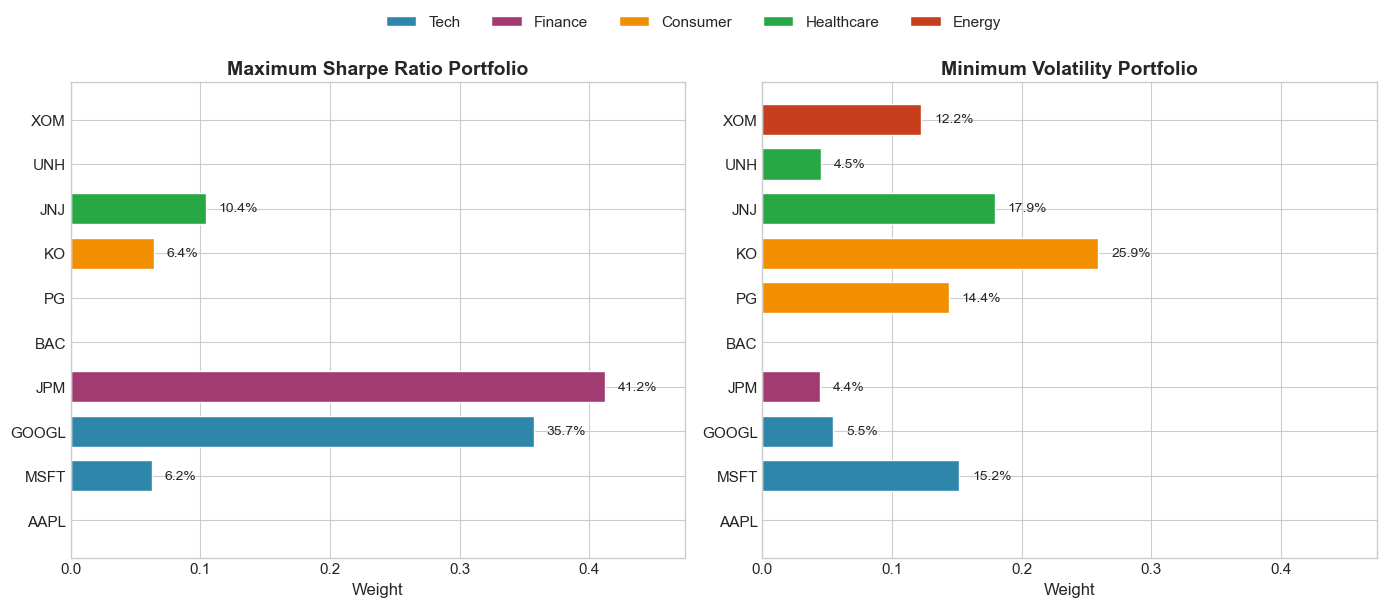

In [23]:
# Create side-by-side weight comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data
sharpe_w = [optimal_portfolios['max_sharpe']['weights'].get(t, 0) for t in ALL_TICKERS]
minvol_w = [optimal_portfolios['min_volatility']['weights'].get(t, 0) for t in ALL_TICKERS]

# Assign colors by sector
sector_colors_list = []
for ticker in ALL_TICKERS:
    for sector, tickers in TICKERS.items():
        if ticker in tickers:
            color_map = {'Tech': '#2E86AB', 'Finance': '#A23B72', 'Consumer': '#F18F01', 
                        'Healthcare': '#28A745', 'Energy': '#C73E1D'}
            sector_colors_list.append(color_map[sector])
            break

# Max Sharpe weights
ax1 = axes[0]
bars1 = ax1.barh(ALL_TICKERS, sharpe_w, color=sector_colors_list, edgecolor='white', height=0.7)
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Maximum Sharpe Ratio Portfolio', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(max(sharpe_w), max(minvol_w)) * 1.15)

# Add percentage labels
for bar, weight in zip(bars1, sharpe_w):
    if weight > 0.01:
        ax1.text(weight + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{weight:.1%}', va='center', fontsize=10)

# Min Volatility weights
ax2 = axes[1]
bars2 = ax2.barh(ALL_TICKERS, minvol_w, color=sector_colors_list, edgecolor='white', height=0.7)
ax2.set_xlabel('Weight', fontsize=12)
ax2.set_title('Minimum Volatility Portfolio', fontsize=14, fontweight='bold')
ax2.set_xlim(0, max(max(sharpe_w), max(minvol_w)) * 1.15)

# Add percentage labels
for bar, weight in zip(bars2, minvol_w):
    if weight > 0.01:
        ax2.text(weight + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{weight:.1%}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[s], edgecolor='white', label=s) for s in TICKERS.keys()]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 7. Backtesting

We test how our optimal portfolios would have performed over the last year using historical data.


In [24]:
def backtest_portfolio(
    returns: pd.DataFrame, 
    weights: dict, 
    initial_value: float = 10000
) -> pd.Series:
    """
    Backtest a portfolio with given weights.
    
    Args:
        returns: DataFrame of daily returns
        weights: Dictionary of {ticker: weight}
        initial_value: Starting portfolio value
    
    Returns:
        Series of portfolio values over time
    """
    weight_array = np.array([weights.get(ticker, 0) for ticker in returns.columns])
    portfolio_returns = returns.dot(weight_array)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    portfolio_values = initial_value * cumulative_returns
    return portfolio_values

def calculate_max_drawdown(values: pd.Series) -> float:
    """Calculate maximum drawdown from a series of portfolio values."""
    rolling_max = values.expanding().max()
    drawdown = (values - rolling_max) / rolling_max
    return drawdown.min()

# Use last year for backtesting
backtest_start = prices.index[-TRADING_DAYS] if len(prices) > TRADING_DAYS else prices.index[0]
backtest_returns = returns.loc[backtest_start:]
benchmark_returns = benchmark_prices[BENCHMARK].pct_change().dropna().loc[backtest_start:]

print(f"Backtest Period: {backtest_returns.index[0].strftime('%Y-%m-%d')} to {backtest_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Trading Days: {len(backtest_returns)}")

# Backtest all portfolios
portfolios_to_test = {
    'Max Sharpe': optimal_portfolios['max_sharpe']['weights'],
    'Min Volatility': optimal_portfolios['min_volatility']['weights'],
    'Equal Weight': optimal_portfolios['equal_weight']['weights'],
}

# Add market-cap weighted (approximate using last prices as proxy)
latest_prices = prices.iloc[-1]
market_cap_proxy = latest_prices / latest_prices.sum()
market_cap_weights = {ticker: market_cap_proxy[ticker] for ticker in ALL_TICKERS}
portfolios_to_test['Price-Weighted'] = market_cap_weights

# Run backtests
backtest_results = {}
INITIAL_INVESTMENT = 10000

for name, weights in portfolios_to_test.items():
    backtest_results[name] = backtest_portfolio(backtest_returns, weights, INITIAL_INVESTMENT)

# Add benchmark (SPY)
benchmark_values = INITIAL_INVESTMENT * (1 + benchmark_returns).cumprod()
backtest_results['S&P 500 (SPY)'] = benchmark_values

print("\nBacktests completed successfully!")


Backtest Period: 2024-12-24 to 2025-12-26
Trading Days: 252

Backtests completed successfully!


In [25]:
# Cumulative returns comparison chart
fig = go.Figure()

colors = {
    'Max Sharpe': '#2E86AB',
    'Min Volatility': '#28A745',
    'Equal Weight': '#F18F01',
    'Price-Weighted': '#A23B72',
    'S&P 500 (SPY)': '#6C757D'
}

for name, values in backtest_results.items():
    fig.add_trace(go.Scatter(
        x=values.index,
        y=values,
        mode='lines',
        name=name,
        line=dict(color=colors.get(name, '#333'), width=2.5 if 'Sharpe' in name else 2),
        hovertemplate=f'{name}<br>Date: %{{x}}<br>Value: $%{{y:,.0f}}<extra></extra>'
    ))

fig.add_hline(y=INITIAL_INVESTMENT, line_dash="dash", line_color="gray", 
              annotation_text=f"Initial: ${INITIAL_INVESTMENT:,}", annotation_position="bottom left")

fig.update_layout(
    title=f'Portfolio Performance Comparison (${INITIAL_INVESTMENT:,} Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
    template='plotly_white',
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="center",
        x=0.5
    ),
    yaxis_tickformat='$,.0f'
)

fig.show()


In [26]:
# Calculate backtest metrics
print("\nBACKTEST PERFORMANCE METRICS")
print("=" * 90)

backtest_metrics = []

for name, values in backtest_results.items():
    # Calculate returns from values
    daily_returns = values.pct_change().dropna()
    
    total_return = (values.iloc[-1] / values.iloc[0]) - 1
    annual_vol = daily_returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (daily_returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / annual_vol
    max_dd = calculate_max_drawdown(values)
    final_value = values.iloc[-1]
    
    backtest_metrics.append({
        'Portfolio': name,
        'Final Value': final_value,
        'Total Return': total_return,
        'Volatility': annual_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    })

backtest_df = pd.DataFrame(backtest_metrics)
backtest_df = backtest_df.sort_values(by='Total Return', ascending=False)

# Format for display
display_backtest = backtest_df.copy()
display_backtest['Final Value'] = display_backtest['Final Value'].apply(lambda x: f"${x:,.0f}")
display_backtest['Total Return'] = display_backtest['Total Return'].apply(lambda x: f"{x:+.2%}")
display_backtest['Volatility'] = display_backtest['Volatility'].apply(lambda x: f"{x:.2%}")
display_backtest['Sharpe Ratio'] = display_backtest['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
display_backtest['Max Drawdown'] = display_backtest['Max Drawdown'].apply(lambda x: f"{x:.2%}")

display(display_backtest.set_index('Portfolio'))



BACKTEST PERFORMANCE METRICS


,Final Value,Total Return,Volatility,Sharpe Ratio,Max Drawdown
Portfolio,,,,,
Max Sharpe,"$14,713",+45.53%,19.34%,1.942,-19.51%
Equal Weight,"$11,897",+18.11%,14.39%,1.094,-12.52%
Min Volatility,"$11,847",+17.76%,11.46%,1.315,-7.29%
Price-Weighted,"$11,823",+17.32%,16.36%,0.939,-14.29%
S&P 500 (SPY),"$11,744",+16.15%,19.50%,0.765,-18.76%


## 8. Risk Analysis

We calculate advanced risk metrics including Value at Risk (VaR), Conditional VaR (CVaR), and market Beta.


In [27]:
def calculate_var(returns: pd.Series, confidence: float = 0.95) -> float:
    """
    Calculate Value at Risk at given confidence level.
    
    Args:
        returns: Series of daily returns
        confidence: Confidence level (e.g., 0.95 for 95%)
    
    Returns:
        VaR as a positive number representing potential loss
    """
    return -np.percentile(returns, (1 - confidence) * 100)

def calculate_cvar(returns: pd.Series, confidence: float = 0.95) -> float:
    """
    Calculate Conditional Value at Risk (Expected Shortfall).
    
    Args:
        returns: Series of daily returns
        confidence: Confidence level
    
    Returns:
        CVaR as a positive number representing expected loss beyond VaR
    """
    var = calculate_var(returns, confidence)
    return -returns[returns <= -var].mean()

def calculate_beta(portfolio_returns: pd.Series, market_returns: pd.Series) -> float:
    """
    Calculate portfolio beta relative to market.
    
    Args:
        portfolio_returns: Series of portfolio daily returns
        market_returns: Series of market (benchmark) daily returns
    
    Returns:
        Beta coefficient
    """
    # Align the series
    aligned = pd.DataFrame({
        'portfolio': portfolio_returns,
        'market': market_returns
    }).dropna()
    
    covariance = np.cov(aligned['portfolio'], aligned['market'])[0, 1]
    market_variance = np.var(aligned['market'])
    return covariance / market_variance

# Calculate risk metrics for key portfolios
print("RISK ANALYSIS")
print("=" * 90)

# Prepare benchmark returns
benchmark_rets = benchmark_prices[BENCHMARK].pct_change().dropna()

risk_analysis = []
portfolios_for_risk = {
    'Max Sharpe': optimal_portfolios['max_sharpe']['weights'],
    'Min Volatility': optimal_portfolios['min_volatility']['weights'],
    'Equal Weight': optimal_portfolios['equal_weight']['weights'],
}

for name, weights in portfolios_for_risk.items():
    # Calculate portfolio returns
    weight_array = np.array([weights.get(ticker, 0) for ticker in returns.columns])
    port_rets = returns.dot(weight_array)
    
    # Calculate metrics
    var_95 = calculate_var(port_rets, 0.95)
    cvar_95 = calculate_cvar(port_rets, 0.95)
    beta = calculate_beta(port_rets, benchmark_rets)
    
    risk_analysis.append({
        'Portfolio': name,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95,
        'Beta': beta,
        'Interpretation': 'Conservative' if beta < 0.8 else ('Moderate' if beta < 1.2 else 'Aggressive')
    })

risk_df = pd.DataFrame(risk_analysis)

# Format for display
display_risk = risk_df.copy()
display_risk['VaR (95%)'] = display_risk['VaR (95%)'].apply(lambda x: f"{x:.2%}")
display_risk['CVaR (95%)'] = display_risk['CVaR (95%)'].apply(lambda x: f"{x:.2%}")
display_risk['Beta'] = display_risk['Beta'].apply(lambda x: f"{x:.3f}")

print("\nRisk Metrics Summary:")
display(display_risk.set_index('Portfolio'))

print("\nInterpretation Guide:")
print("  • VaR (95%): Maximum expected daily loss with 95% confidence")
print("  • CVaR (95%): Expected loss when VaR is exceeded (tail risk)")
print("  • Beta: Portfolio sensitivity to market movements (1.0 = moves with market)")


RISK ANALYSIS

Risk Metrics Summary:


,VaR (95%),CVaR (95%),Beta,Interpretation
Portfolio,,,,
Max Sharpe,1.53%,2.40%,0.868,Moderate
Min Volatility,0.97%,1.34%,0.401,Conservative
Equal Weight,1.13%,1.63%,0.634,Conservative



Interpretation Guide:
  • VaR (95%): Maximum expected daily loss with 95% confidence
  • CVaR (95%): Expected loss when VaR is exceeded (tail risk)
  • Beta: Portfolio sensitivity to market movements (1.0 = moves with market)


## 9. Investment Recommendations

Based on our analysis, here are tailored recommendations for different investor profiles.


In [28]:
print("=" * 90)
print("INVESTMENT RECOMMENDATIONS BY INVESTOR PROFILE")
print("=" * 90)

# Investor profiles
profiles = {
    'Conservative': {
        'portfolio': 'min_volatility',
        'description': 'Prioritizes capital preservation and stability',
        'risk_tolerance': 'Low',
        'time_horizon': '3-5 years'
    },
    'Moderate': {
        'portfolio': 'equal_weight',
        'description': 'Seeks balance between growth and risk management',
        'risk_tolerance': 'Medium',
        'time_horizon': '5-10 years'
    },
    'Aggressive': {
        'portfolio': 'max_sharpe',
        'description': 'Maximizes risk-adjusted returns, accepts higher volatility',
        'risk_tolerance': 'High',
        'time_horizon': '10+ years'
    }
}

for profile_name, profile_data in profiles.items():
    port_name = profile_data['portfolio']
    port_data = optimal_portfolios[port_name]
    metrics = port_data['metrics']
    
    print(f"\n{profile_name.upper()} INVESTOR")
    print("-" * 60)
    print(f"Profile: {profile_data['description']}")
    print(f"Risk Tolerance: {profile_data['risk_tolerance']}")
    print(f"Time Horizon: {profile_data['time_horizon']}")
    print(f"\nRecommended Portfolio: {port_name.replace('_', ' ').title()}")
    print(f"   Expected Return: {metrics['return']:.2%}")
    print(f"   Expected Volatility: {metrics['volatility']:.2%}")
    print(f"   Sharpe Ratio: {metrics['sharpe']:.2f}")
    
    # Top holdings
    weights = port_data['weights']
    sorted_weights = sorted(weights.items(), key=lambda x: -x[1])
    top_holdings = [(t, w) for t, w in sorted_weights if w > 0.01][:5]
    
    print(f"\n   Top Holdings:")
    for ticker, weight in top_holdings:
        sector = next((s for s, tickers in TICKERS.items() if ticker in tickers), 'Unknown')
        print(f"      - {ticker} ({sector}): {weight:.1%}")


INVESTMENT RECOMMENDATIONS BY INVESTOR PROFILE

CONSERVATIVE INVESTOR
------------------------------------------------------------
Profile: Prioritizes capital preservation and stability
Risk Tolerance: Low
Time Horizon: 3-5 years

Recommended Portfolio: Min Volatility
   Expected Return: 12.34%
   Expected Volatility: 10.19%
   Sharpe Ratio: 1.01

   Top Holdings:
      - KO (Consumer): 25.9%
      - JNJ (Healthcare): 17.9%
      - MSFT (Tech): 15.2%
      - PG (Consumer): 14.4%
      - XOM (Energy): 12.2%

MODERATE INVESTOR
------------------------------------------------------------
Profile: Seeks balance between growth and risk management
Risk Tolerance: Medium
Time Horizon: 5-10 years

Recommended Portfolio: Equal Weight
   Expected Return: 18.09%
   Expected Volatility: 11.95%
   Sharpe Ratio: 1.35

   Top Holdings:
      - AAPL (Tech): 10.0%
      - MSFT (Tech): 10.0%
      - GOOGL (Tech): 10.0%
      - JPM (Finance): 10.0%
      - BAC (Finance): 10.0%

AGGRESSIVE INVESTOR
-----

In [29]:
# Asset allocation summary table
print("\n" + "=" * 90)
print("COMPLETE ASSET ALLOCATION TABLE")
print("=" * 90)

allocation_data = []
for ticker in ALL_TICKERS:
    sector = next((s for s, tickers in TICKERS.items() if ticker in tickers), 'Unknown')
    row = {
        'Ticker': ticker,
        'Sector': sector,
        'Max Sharpe': optimal_portfolios['max_sharpe']['weights'].get(ticker, 0),
        'Min Vol': optimal_portfolios['min_volatility']['weights'].get(ticker, 0),
        'Equal Wt': optimal_portfolios['equal_weight']['weights'].get(ticker, 0)
    }
    allocation_data.append(row)

allocation_df = pd.DataFrame(allocation_data)

# Format percentages
for col in ['Max Sharpe', 'Min Vol', 'Equal Wt']:
    allocation_df[col] = allocation_df[col].apply(lambda x: f"{x:.1%}" if x > 0.001 else "-")

print("\n")
display(allocation_df.set_index(['Sector', 'Ticker']))



COMPLETE ASSET ALLOCATION TABLE




Max Sharpe Min Vol Equal Wt
Sector     Ticker                            
Tech       AAPL            -       -    10.0%
           MSFT         6.2%   15.2%    10.0%
           GOOGL       35.7%    5.5%    10.0%
Finance    JPM         41.2%    4.4%    10.0%
           BAC             -       -    10.0%
Consumer   PG              -   14.4%    10.0%
           KO           6.4%   25.9%    10.0%
Healthcare JNJ         10.4%   17.9%    10.0%
           UNH             -    4.5%    10.0%
Energy     XOM             -   12.2%    10.0%

In [30]:
print("\n" + "=" * 90)
print("REBALANCING RECOMMENDATIONS")
print("=" * 90)

print("""
REBALANCING FREQUENCY:
   - Conservative portfolios: Quarterly rebalancing
   - Moderate portfolios: Semi-annual rebalancing  
   - Aggressive portfolios: Annual rebalancing (to capture momentum)

REBALANCING TRIGGERS:
   - Any position drifts more than 5% from target allocation
   - After significant market events (>10% market move)
   - Following major life events or changes in risk tolerance

REBALANCING BEST PRACTICES:
   1. Set calendar reminders for periodic reviews
   2. Use tax-advantaged accounts for frequent rebalancing
   3. Consider transaction costs when making small adjustments
   4. Rebalance by directing new investments to underweight positions
   5. Review the entire portfolio, not just individual positions

IMPORTANT DISCLAIMERS:
   - Past performance does not guarantee future results
   - These recommendations are based on historical data analysis
   - Consult a financial advisor before making investment decisions
   - Consider your personal tax situation and investment constraints
   - Market conditions can change rapidly, affecting optimal allocations
""")

print("\n" + "=" * 90)
print("ANALYSIS COMPLETE")
print("=" * 90)
print(f"""
Summary of Key Findings:
   - Analyzed {len(ALL_TICKERS)} stocks across {len(TICKERS)} sectors
   - Generated {N_PORTFOLIOS:,} random portfolios for efficient frontier
   - Identified optimal portfolios using PyPortfolioOpt
   - Backtested strategies over {len(backtest_returns)} trading days
   
Recommended Approach:
   Start with the portfolio matching your risk profile, then adjust
   based on your specific circumstances and investment goals.
""")



REBALANCING RECOMMENDATIONS

REBALANCING FREQUENCY:
   - Conservative portfolios: Quarterly rebalancing
   - Moderate portfolios: Semi-annual rebalancing  
   - Aggressive portfolios: Annual rebalancing (to capture momentum)

REBALANCING TRIGGERS:
   - Any position drifts more than 5% from target allocation
   - After significant market events (>10% market move)
   - Following major life events or changes in risk tolerance

REBALANCING BEST PRACTICES:
   1. Set calendar reminders for periodic reviews
   2. Use tax-advantaged accounts for frequent rebalancing
   3. Consider transaction costs when making small adjustments
   4. Rebalance by directing new investments to underweight positions
   5. Review the entire portfolio, not just individual positions

IMPORTANT DISCLAIMERS:
   - Past performance does not guarantee future results
   - These recommendations are based on historical data analysis
   - Consult a financial advisor before making investment decisions
   - Consider your pers